In [1]:
import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import statsmodels.api as sm
import statsmodels


from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [2]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")


In [3]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

# Load Data

In [4]:
#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'
unemployment_rate_code = 'UNRATE'
cpi_code = 'CORESTICKM157SFRBATL'
real_rate_code = 'REAINTRATREARAT1MO'

cpi_urban = 'CPIAUCSL'
inf_10y = 'T10YIEM'
ff_rate_code = 'EFFR'

#GDP GAP
p_gdp = 'GDPPOT'

In [5]:
fred_df = pdr.DataReader(['FEDFUNDS','PCEPILFE','GDPC1','GDPPOT'], data_source, start_date)

# Analysis

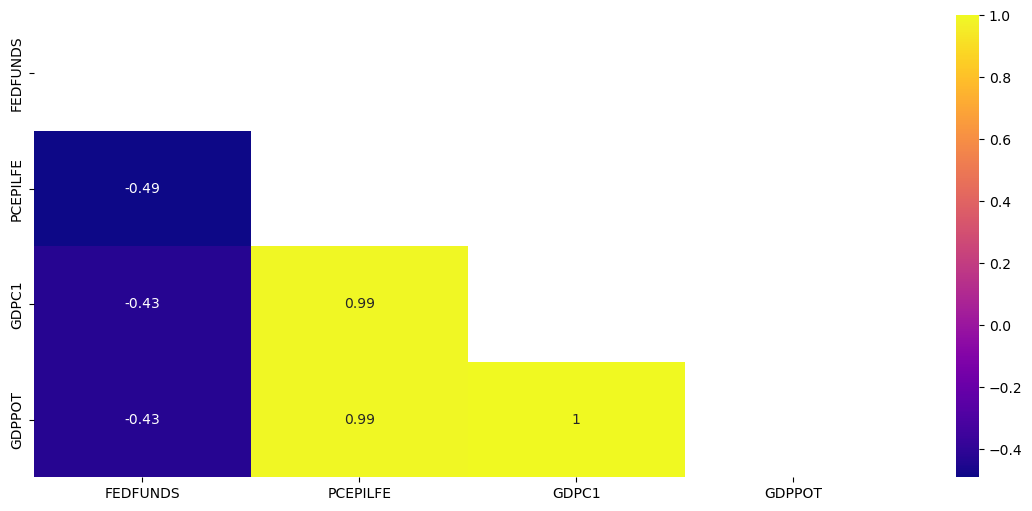

In [6]:
#t_df = df

plt.figure(figsize=(14,6))
mask = np.zeros_like(fred_df.corr())
mask[np.triu_indices_from(mask)] = True
_p = sns.heatmap(fred_df.corr().round(2), annot=True, mask=mask, cmap="plasma")

# Graph

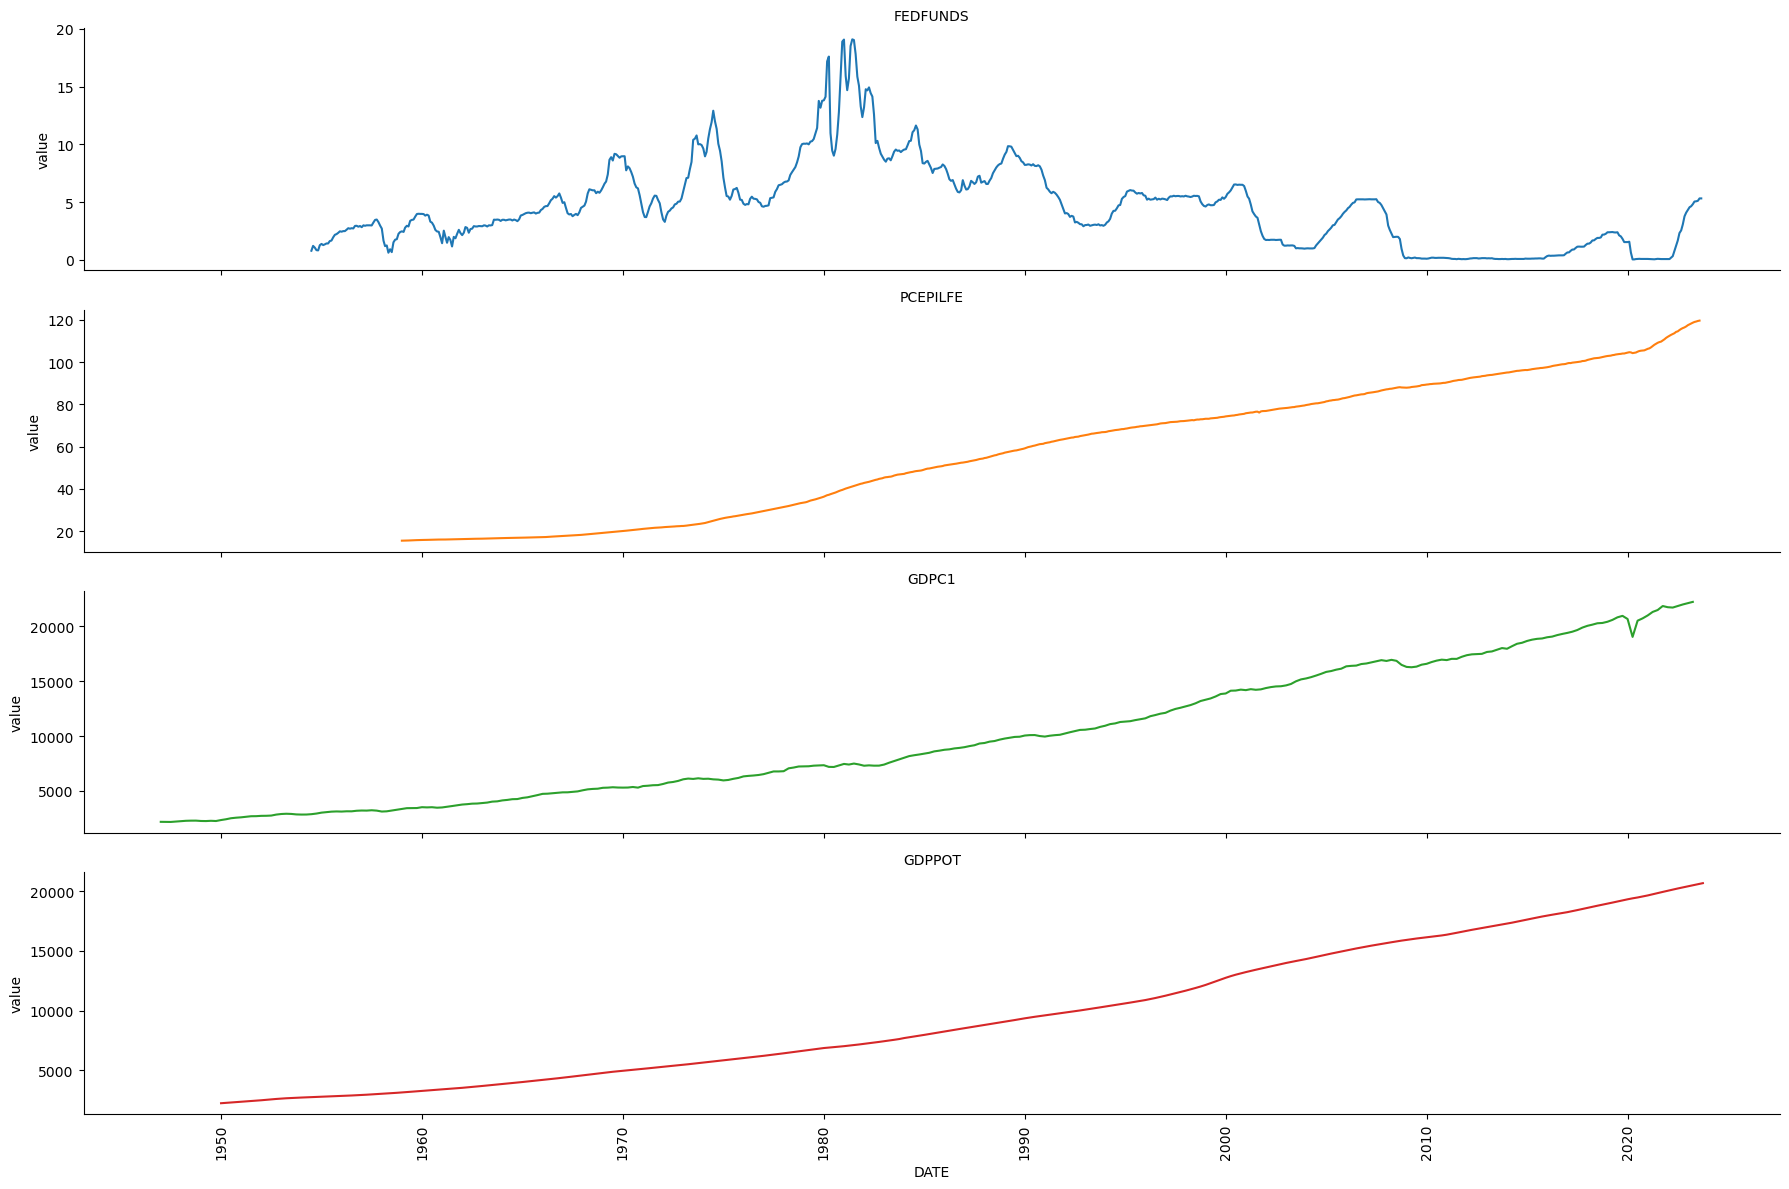

In [7]:
long_df = fred_df.copy()
long_df.reset_index(inplace=True)

long_df = long_df.melt(id_vars=['DATE'])


# Graph
g = sns.FacetGrid(long_df, col='variable', hue='variable',
                  height=3, aspect=6,col_wrap=1, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.lineplot, y="value", x="DATE")

plt.show()

# Taylor
The FRED® Blog
https://fredblog.stlouisfed.org/2014/04/the-taylor-rule/

This graph shows in blue the Taylor Rule, which is a simple formula that John Taylor devised to guide policymakers. It calculates what the federal funds rate should be, as a function of the output gap and current inflation. Here, we measure the output gap as the difference between potential output (published by the Congressional Budget Office) and real GDP. Inflation is measured by changes in the CPI, and we use a target inflation rate of 2%. We also assume a steady-state real interest rate of 2%. These are a lot of assumptions, and you are welcome to change them on the graph by playing around with the formula to see how the Taylor Rule matches up with the effective federal funds rate. To read up on the Taylor Rule, see the original article or an article by former St. Louis Fed president William Poole.

How this graph was created: To create a new series from several series, first add the series by modifying the existing series in the “Graph” tab. Once you have assembled them all, expand the series section in the same tab and “create your own transformation.” Finally, as the axis legend has become unwieldy, remove it by checking off the mark in the graph tab.

Suggested by: Christian Zimmermann

Update: A previous version did not multiply the output gap by 100.

View on FRED, series used in this post: FEDFUNDS, GDPC1, GDPDEF, GDPPOT

# Fred Calculations

In [8]:
base_df = pd.read_csv('./data/fred.csv', parse_dates=['fund_date','taylor_date'])
base1_df = base_df[['fund_date','FEDFUNDS']].dropna().copy()
base1_df.sort_values(by='fund_date', inplace = True)
base2_df = base_df[['taylor_date','GDPPOT_GDPC1_GDPDEF_PC1']].copy()
base2_df.sort_values(by='taylor_date', inplace = True)

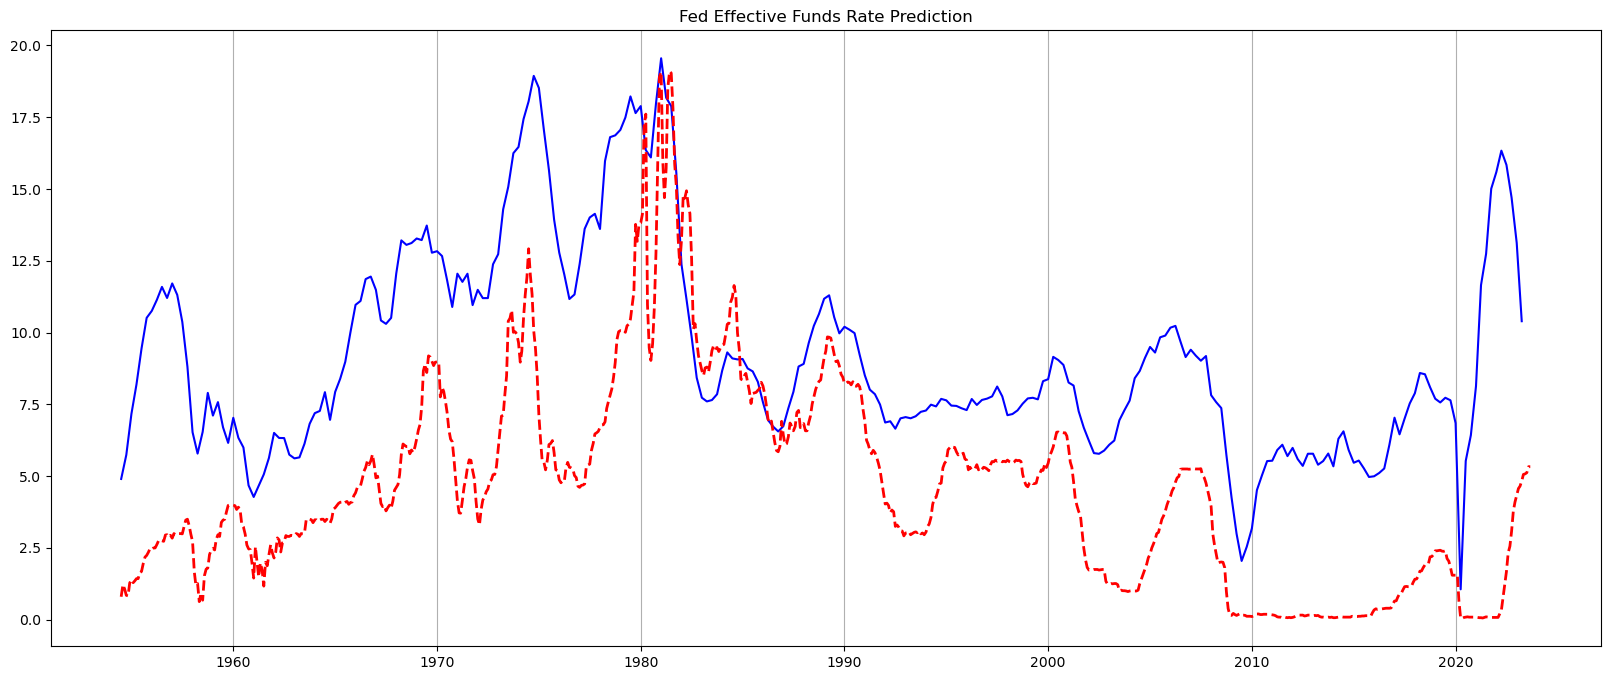

In [9]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(base2_df['taylor_date'], base2_df['GDPPOT_GDPC1_GDPDEF_PC1'], 'blue')
ax.plot(base1_df['fund_date'], base1_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

## Calculation 1

In [10]:
gdpc1_df = pd.read_csv('./data/GDPC1.csv', parse_dates=['observation_date'], skiprows=10)
print('gdpc1_df:', gdpc1_df.shape)
gdppot_df = pd.read_csv('./data/GDPPOT.csv', parse_dates=['observation_date'], skiprows=10)
print('gdppot_df:', gdppot_df.shape)
gdpdef_df = pd.read_csv('./data/GDPDEF.csv', parse_dates=['observation_date'], skiprows=10)
print('gdpdef_df:', gdpdef_df.shape)
fed_df = pd.read_csv('./data/FEDFUNDS.csv', parse_dates=['observation_date'], skiprows=10)
print('fed_df:', fed_df.shape)

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


In [11]:
taylor_df = gdpc1_df.merge(gdppot_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                    .merge(gdpdef_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                    .merge(fed_df, how='outer', left_on='observation_date', right_on='observation_date')
    
taylor_df.dropna(inplace=True)
taylor_df

,observation_date,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS
29,1954-07-01,2880.482,2727.099666,0.7,0.80
30,1954-10-01,2936.852,2743.726730,0.8,0.85
31,1955-01-01,3020.746,2760.136280,1.0,1.39
32,1955-04-01,3069.910,2777.950765,1.3,1.43
33,1955-07-01,3111.379,2795.471543,1.9,1.68
...,...,...,...,...,...
300,2022-04-01,21708.160,20153.810000,7.7,0.33
301,2022-07-01,21851.134,20245.660000,7.3,1.68
302,2022-10-01,21989.981,20334.210000,6.4,3.08
303,2023-01-01,22112.329,20420.680000,5.3,4.33


long_df: (1104, 3)


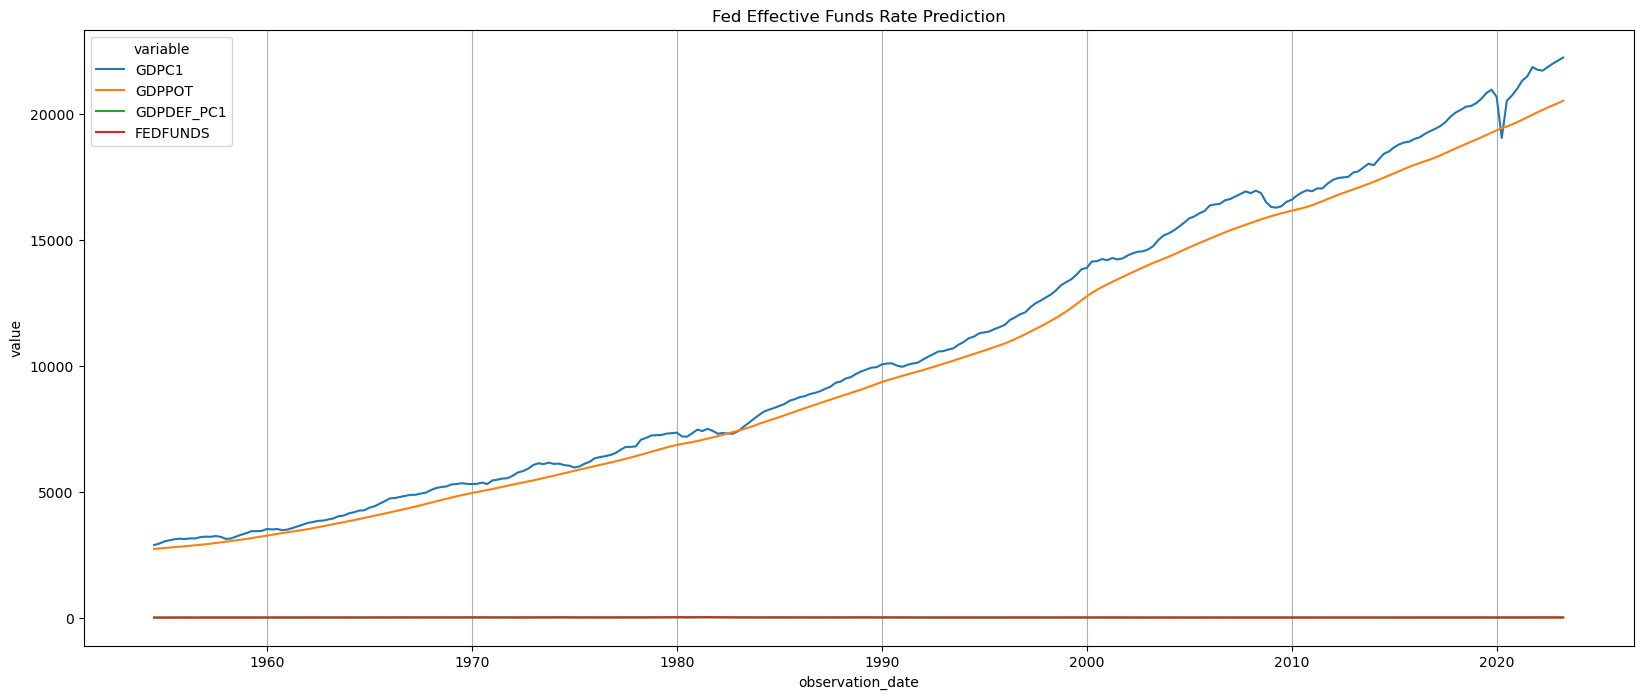

In [12]:
# Long 
long_df = taylor_df.melt(id_vars=['observation_date'])
print('long_df:', long_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
#ax.plot(long_df['observation_date'], long_df['value'], color='variable')
sns.lineplot(x = 'observation_date', y = 'value', data=long_df, hue='variable')

ax.set(title='Fed Effective Funds Rate Prediction');

In [13]:
#taylor_df = pd.DataFrame()
taylor_df['ffef_tr'] = taylor_df['GDPDEF_PC1'] + 2    \
                        +0.5*(taylor_df['GDPDEF_PC1'] - 2)    \
                        +0.5*(taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100

taylor_df['gap_inf'] = 0.5*(taylor_df['GDPDEF_PC1'] - 2) 
taylor_df['gap_gdp'] = 0.5*(taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100

taylor_df.tail(10)

,observation_date,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,ffef_tr,gap_inf,gap_gdp
295,2021-01-01,20990.541,19661.616617,2.5,0.09,8.129489,0.25,3.379489
296,2021-04-01,21309.544,19756.957426,4.5,0.07,11.679215,1.25,3.929215
297,2021-07-01,21483.083,19856.923211,5.1,0.10,12.744692,1.55,4.094692
298,2021-10-01,21847.602,19957.974448,6.2,0.08,15.034016,2.10,4.734016
299,2022-01-01,21738.871,20057.880000,6.9,0.08,15.540351,2.45,4.190351
300,2022-04-01,21708.160,20153.810000,7.7,0.33,16.406219,2.85,3.856219
301,2022-07-01,21851.134,20245.660000,7.3,1.68,15.914983,2.65,3.964983
302,2022-10-01,21989.981,20334.210000,6.4,3.08,14.671392,2.20,4.071392
303,2023-01-01,22112.329,20420.680000,5.3,4.33,13.092000,1.65,4.142000
304,2023-04-01,22225.350,20511.890000,3.5,4.83,10.426748,0.75,4.176748


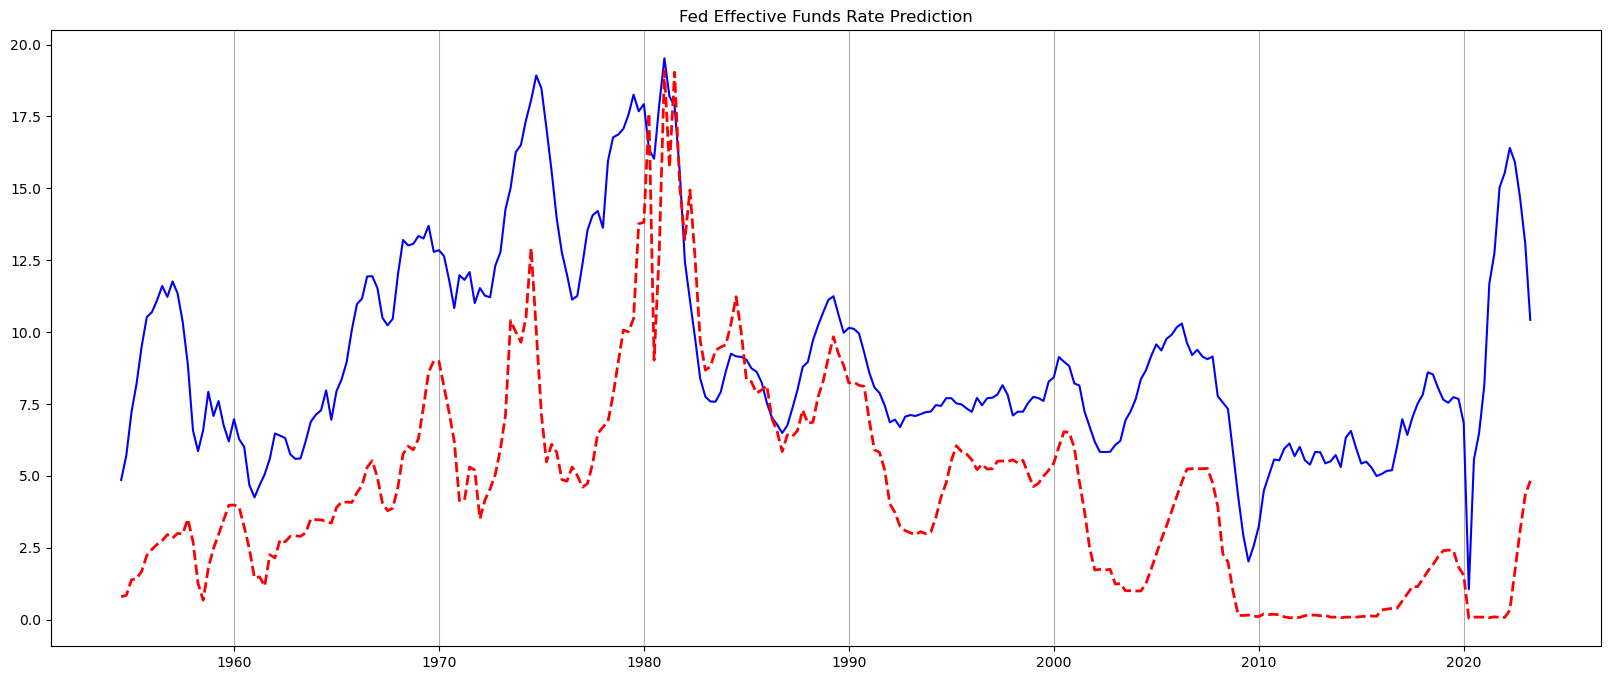

In [14]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df['observation_date'], taylor_df['ffef_tr'], 'blue')
ax.plot(taylor_df['observation_date'], taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

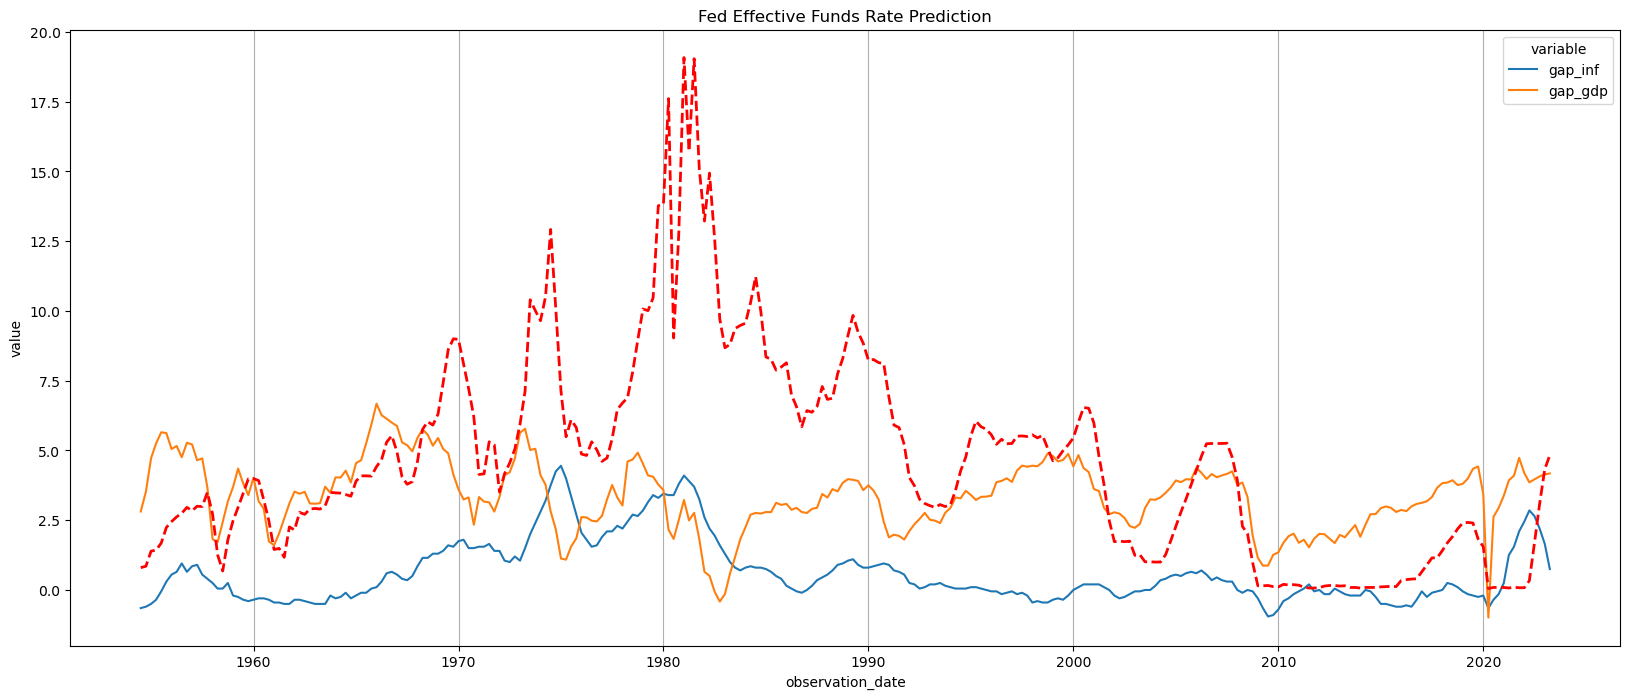

In [15]:
long_df = taylor_df[['observation_date','gap_inf','gap_gdp']].melt(id_vars=['observation_date'])

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
sns.lineplot(data=long_df, x = 'observation_date', y = 'value', hue='variable')
ax.plot(taylor_df['observation_date'], taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

# Taylor Rule

<b> Variables </b>
- nominal funds rate - FEDFUNDS
- real interest rate - REAINTRATREARAT1MO
- inflation - CPIAUCSL
- real gpd - real
- target = 0.02

#  Federal Reserve Economic Data Service
data_source = 'fred'
unemployment_rate_code = 'UNRATE'
cpi_code = 'CORESTICKM157SFRBATL'
real_rate_code = 'REAINTRATREARAT1MO'

cpi_urban = 'CPIAUCSL'
inf_10y = 'T10YIEM'
ff_rate_code = 'EFFR'

#GDP GAP
p_gdp = 'GDPPOT'

In [16]:
t1_df = pdr.DataReader(['FEDFUNDS','REAINTRATREARAT1MO','CORESTICKM157SFRBATL','GDPC1','GDPPOT'], data_source, start_date)
#t1_df.dropna(inplace=True)
print('t1_df:', t1_df.shape)
t1_df.head(5)

t1_df: (862, 5)


,FEDFUNDS,REAINTRATREARAT1MO,CORESTICKM157SFRBATL,GDPC1,GDPPOT
DATE,,,,,
1947-01-01,NaN,NaN,NaN,2182.681,NaN
1947-04-01,NaN,NaN,NaN,2176.892,NaN
1947-07-01,NaN,NaN,NaN,2172.432,NaN
1947-10-01,NaN,NaN,NaN,2206.452,NaN
1948-01-01,NaN,NaN,NaN,2239.682,NaN


In [17]:
t2_df = pd.read_csv('./data/Holston_Laubach_Williams_real_time_estimates.csv', parse_dates=['Date'], skiprows=5)
t2_df.set_index('Date', inplace=True)
print('t2_df:', t2_df.shape)
t2_df.head(5)

t2_df: (250, 3)


,Growth_g,Real_Interest_Rate,Output_Gap
Date,,,
1961-01-01,4.828759,5.493491,-3.755573
1961-04-01,4.989798,5.682399,-3.407557
1961-07-01,4.923091,5.609036,-2.640213
1961-10-01,4.910719,5.592011,-1.931028
1962-01-01,4.767864,5.431519,-1.116593


In [18]:
f1_df = t1_df.merge(t2_df, how='outer', left_index=True, right_index=True)
f1_df.dropna(inplace=True)
f1_df.index.rename('Date', inplace=True)
f1_df.head()

,FEDFUNDS,REAINTRATREARAT1MO,CORESTICKM157SFRBATL,GDPC1,GDPPOT,Growth_g,Real_Interest_Rate,Output_Gap
Date,,,,,,,,
1982-01-01,13.22,2.464018,0.36879,7295.631,7202.119830,2.956000,2.966393,-3.849021
1982-04-01,14.94,8.803434,0.90752,7328.912,7255.183995,3.080303,3.046039,-4.753866
1982-07-01,12.59,7.161898,0.56243,7300.896,7309.422617,2.918558,2.946979,-5.089924
1982-10-01,9.71,2.752972,0.29105,7303.817,7365.185870,2.863820,2.839540,-5.658898
1983-01-01,8.68,4.469162,0.53839,7400.066,7421.653951,2.990278,2.990787,-5.548596


In [19]:
target_inf = 2
alpha = 0.5
beta = 0.5

In [20]:
f1_df['gap_gdp'] = alpha * (f1_df['GDPC1'] - f1_df['GDPPOT']) / f1_df['GDPPOT'] * 100
f1_df['gap_inf'] = beta * (f1_df['CORESTICKM157SFRBATL'] - target_inf)

f1_df['ffef_tr'] = f1_df['Real_Interest_Rate']  \
                        + f1_df['CORESTICKM157SFRBATL']  \
                        + f1_df['gap_gdp']  \
                        + f1_df['gap_inf']

f1_df.head()

,FEDFUNDS,REAINTRATREARAT1MO,CORESTICKM157SFRBATL,GDPC1,GDPPOT,Growth_g,Real_Interest_Rate,Output_Gap,gap_gdp,gap_inf,ffef_tr
Date,,,,,,,,,,,
1982-01-01,13.22,2.464018,0.36879,7295.631,7202.119830,2.956000,2.966393,-3.849021,0.649192,-0.815605,3.168770
1982-04-01,14.94,8.803434,0.90752,7328.912,7255.183995,3.080303,3.046039,-4.753866,0.508106,-0.546240,3.915425
1982-07-01,12.59,7.161898,0.56243,7300.896,7309.422617,2.918558,2.946979,-5.089924,-0.058326,-0.718785,2.732298
1982-10-01,9.71,2.752972,0.29105,7303.817,7365.185870,2.863820,2.839540,-5.658898,-0.416615,-0.854475,1.859500
1983-01-01,8.68,4.469162,0.53839,7400.066,7421.653951,2.990278,2.990787,-5.548596,-0.145439,-0.730805,2.652933


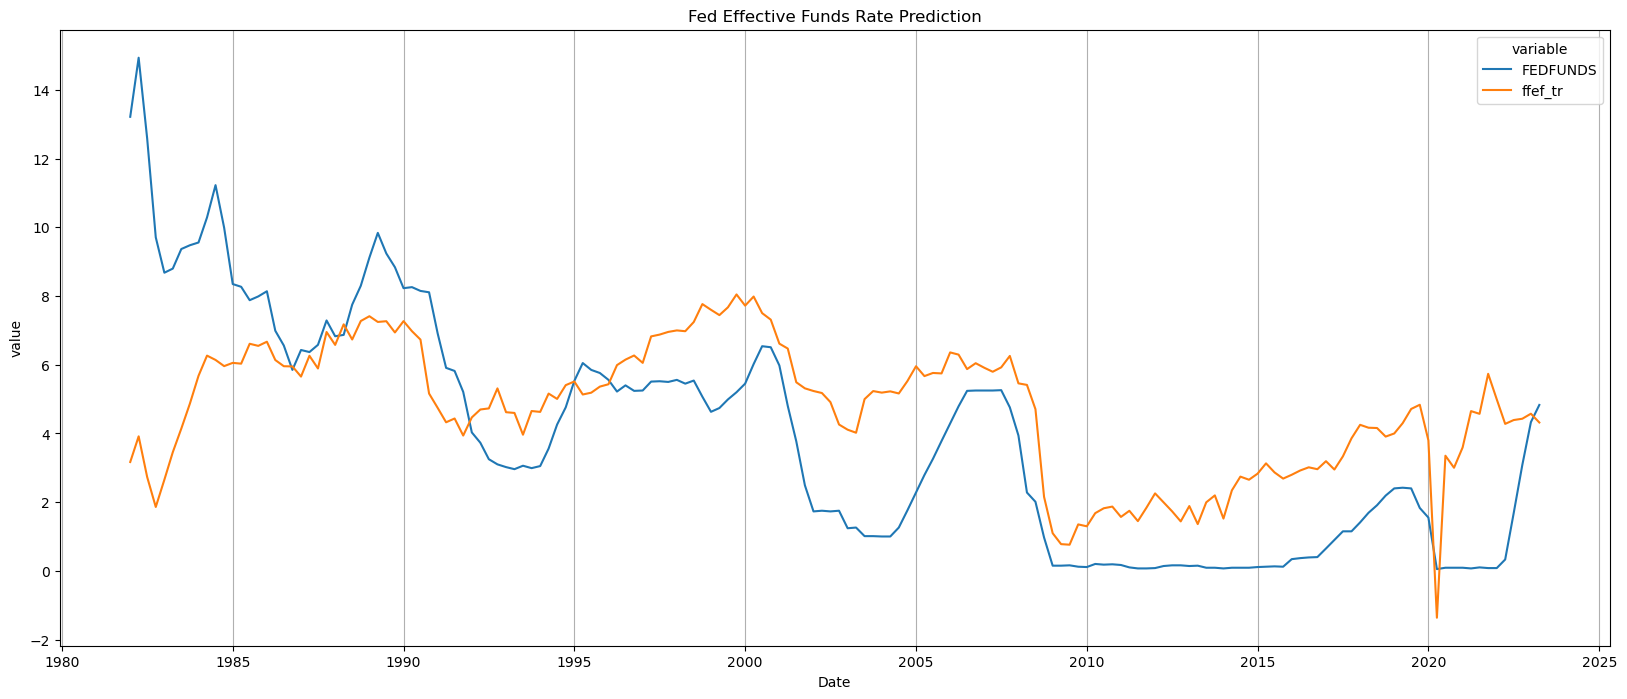

In [21]:
long_df = f1_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['Date','FEDFUNDS','ffef_tr']].melt(id_vars=['Date'])

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
sns.lineplot(data=long_df, x = 'Date', y = 'value', hue='variable')
#ax.plot(taylor_df['observation_date'], taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

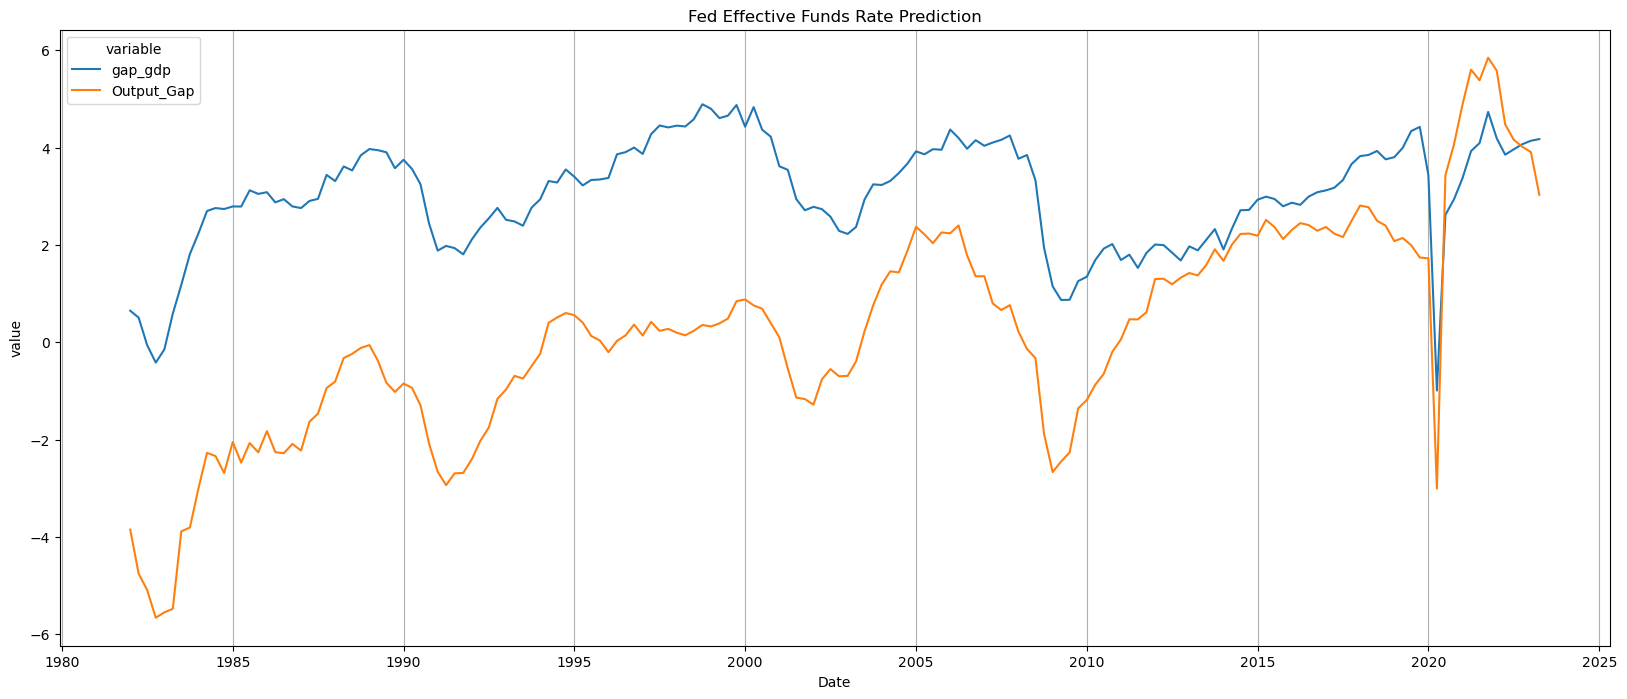

In [22]:
long_df = f1_df.copy()
long_df.reset_index(inplace=True)
long_df = long_df[['Date','gap_gdp','Output_Gap']].melt(id_vars=['Date'])

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
sns.lineplot(data=long_df, x = 'Date', y = 'value', hue='variable')
#ax.plot(taylor_df['observation_date'], taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

ax.set(title='Fed Effective Funds Rate Prediction');

# Regression Models 

In [23]:
taylor_df.head()

,observation_date,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,ffef_tr,gap_inf,gap_gdp
29,1954-07-01,2880.482,2727.099666,0.7,0.80,4.862188,-0.65,2.812188
30,1954-10-01,2936.852,2743.726730,0.8,0.85,5.719397,-0.60,3.519397
31,1955-01-01,3020.746,2760.136280,1.0,1.39,7.220957,-0.50,4.720957
32,1955-04-01,3069.910,2777.950765,1.3,1.43,8.204939,-0.35,5.254939
33,1955-07-01,3111.379,2795.471543,1.9,1.68,9.500343,-0.05,5.650343


In [25]:
t_df = taylor_df.copy()
#t_df.set_index()